# Planet transit simulations

Here we try to plot an exoplanet transit spectrum.

In [1]:
# %load ~/Desktop/defaults.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import astropy.units as u

### Get exoplanet transit spectrum

We can use Caroline Morley's models from [her website](https://www.carolinemorley.com/models).  We want:

"MORLEY ET AL. 2015: SUB-NEPTUNE MODELS INCLUDING THE EFFECTS OF CLOUDS AND HAZES"
> Models of GJ 1214b “analogs” from Morley et al. 2015, including cloudy, hazy, and cloud-free models. These include thermal emission, transmission, and albedo spectra. Other similar models available upon request. 

Let's read in the transmission spectra data.

In [3]:
#! cat ../data/Morley2015_models/published_models/_README.txt

In [4]:
! ls ../data/Morley2015_models/published_models/emission_spectra/cloud-free/

gj1214-1000x-0.3x-nc.spec gj1214-150x-1x-nc.spec    gj1214-300x-0.3x-nc.spec
gj1214-1000x-10x-nc.spec  gj1214-150x-3x-nc.spec    gj1214-300x-10x-nc.spec
gj1214-1000x-1x-nc.spec   gj1214-200x-0.3x-nc.spec  gj1214-300x-1x-nc.spec
gj1214-1000x-3x-nc.spec   gj1214-200x-10x-nc.spec   gj1214-300x-3x-nc.spec
gj1214-100x-0.3x-nc.spec  gj1214-200x-1x-nc.spec    gj1214-50x-0.3x-nc.spec
gj1214-100x-10x-nc.spec   gj1214-200x-3x-nc.spec    gj1214-50x-10x-nc.spec
gj1214-100x-1x-nc.spec    gj1214-250x-0.3x-nc.spec  gj1214-50x-1x-nc.spec
gj1214-100x-3x-nc.spec    gj1214-250x-10x-nc.spec   gj1214-50x-30x-nc.spec
gj1214-150x-0.3x-nc.spec  gj1214-250x-1x-nc.spec    gj1214-50x-3x-nc.spec
gj1214-150x-10x-nc.spec   gj1214-250x-3x-nc.spec


The file names describe the contents.
> cloud-free:
gj1214-METALLICITY-INCIDENTFLUX-nc.[[append]]
e.g. gj1214-50x-0.3x-nc.spec is 50x solar, 0.3x GJ 1214b's
	incident flux, and cloud-free, emission spectrum. 

In [5]:
! head ../data/Morley2015_models/published_models/transmission_spectra/cloud-free/gj1214-100x-1x-nc.out

wavelength (microns) 	 radius (km) 
      30.0000   17201.5230     
      29.9911   17065.3259     
      29.9822   17110.6001     
      29.9733   17276.7692     
      29.9644   17066.4351     
      29.9555   17084.3500     
      29.9466   17123.8913     
      29.9377   17213.5251     
      29.9289   17356.1280     


In [6]:
fn = '../data/Morley2015_models/published_models/transmission_spectra/cloud-free/gj1214-100x-1x-nc.out'
df_raw = pd.read_csv(fn, delim_whitespace=True, names=['wl_um', 'radius_km'], skiprows=1)

In [7]:
df_raw.head()

,wl_um,radius_km
0,30.0000,17201.5230
1,29.9911,17065.3259
2,29.9822,17110.6001
3,29.9733,17276.7692
4,29.9644,17066.4351


In [8]:
nir_bounds = (df_raw.wl_um > 1.15) & (df_raw.wl_um < 2.45)
df = df_raw#[nir_bounds].copy()
df = df.reset_index(drop=True)

In [9]:
R_scale = u.km/u.earthRad

In [10]:
df['radius_earth'] = df.radius_km * R_scale.to(u.dimensionless_unscaled)

In [11]:
R_GJ1215 = 0.2064 #R_sun

The peak transit depth is:

transit_depth = $\frac{R^2_{\mathrm{planet}}}{R^2_\star} $

In [12]:
df['radius_Rstar'] = df.radius_km*(u.km/(R_GJ1215*u.solRad)).to(u.dimensionless_unscaled)

In [13]:
df['transit_depth'] = df.radius_Rstar**2

In [14]:
df.head()

,wl_um,radius_km,radius_earth,radius_Rstar,transit_depth
0,30.0000,17201.5230,2.696967,0.119794,0.014351
1,29.9911,17065.3259,2.675613,0.118846,0.014124
2,29.9822,17110.6001,2.682711,0.119161,0.014199
3,29.9733,17276.7692,2.708764,0.120318,0.014476
4,29.9644,17066.4351,2.675787,0.118853,0.014126


In [15]:
import seaborn as sns

In [16]:
sns.set_context('talk')

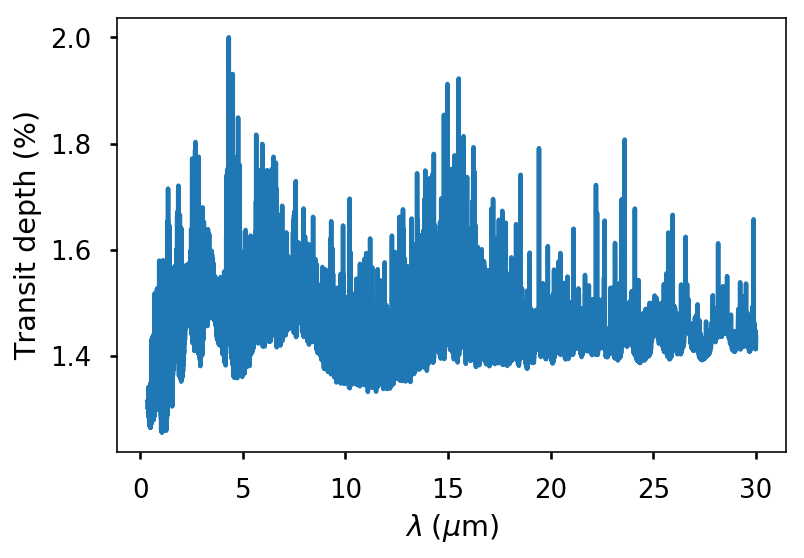

In [17]:
#plt.figure(figsize=(20,10))
plt.plot(df.wl_um, df.transit_depth*100.0)
plt.xlabel('$\lambda \;(\mu \mathrm{m})$')
plt.xlabel('$\lambda \;(\mu \mathrm{m})$')
plt.ylabel('Transit depth (%)')

In [18]:
df.transit_depth.std()

0.0008709565202580554

Neat!

### Now pass it through a computed model spectrum modified with Starfish

From Wikipedia:

$M = {0.157\pm0.019} M_{\odot}$   
$R = 0.2064^{+0.0086}_{-0.0096} R_{\odot}$  
L = 0.00328 L_sun  
[Fe/H] = 0.39+/- 0.15  
P_rot = 25 days  
Teff = 3026±130  
logg = 4.991  
vsini $<$2.0

distance = 14 pc


What is the solid angle?

$\Omega = \frac{R^2}{d^2}$

In [19]:
omega = (0.2064*u.Rsun)**2/(14.0*u.pc)**2

Starfish needs the log Omega.

In [20]:
np.log10(omega.to(u.dimensionless_unscaled))

<Quantity -18.9566937691683>

Following Rackham et al. 2017, with a 3.2% surface coverage of spots:

In [21]:
np.log10(0.032*omega.to(u.dimensionless_unscaled))

<Quantity -20.451543790848394>

and delta T contrast = 354

In [22]:
T_spot = 3026-354
T_spot

2672

We need to make "synthetic data" in this directory:
> $nubble/data/synthetic/GJ1214_synthetic.hdf5

In [23]:
! mkdir ../data/synthetic

mkdir: ../data/synthetic: File exists


In [24]:
! cp ../../xveganx/data/IGRINS/reduced/Anon1_20141118_073.hdf5 ../data/synthetic/GJ1214_synthetic.hdf5
! cp ../../xveganx/data/IGRINS/reduced/Anon1_20141118_073.hdf5 ../data/synthetic/demo.hdf5

In [25]:
import h5py

In [26]:
f2 = h5py.File('../data/synthetic/demo.hdf5', mode='r')

In [27]:
list(f2.keys())

['fls', 'masks', 'sigmas', 'wls']

In [28]:
list(f2['masks'])[0:5]

[1, 1, 1, 1, 1]

We need to mimic these columns.

In [29]:
f2.close()

In [30]:
f1 = h5py.File('../data/synthetic/GJ1214_synthetic.hdf5', mode='w')

In [31]:
list(f1.keys())

[]

Let's pick a spectral resolution:

R ~ 1000   
3.0 pixels per slit sampling  
delta_lam = 1.1 - 1.6 micron

res = lam / dlam   
dlam= lam / res

In [32]:
Res = 1000.0
samp = 3.0
delta_lam = 1.3 #nm

In [33]:
1.3 /3.0

0.43333333333333335

In [34]:
500 / 0.43

1162.7906976744187

So there will be about 1200 spectral resolution elements

In [35]:
wl_arr = np.arange(11000.0, 16000.0, 4)

In [36]:
wl_arr.shape

(1250,)

In [37]:
f1['wls'] = wl_arr

In [38]:
f1['fls'] = wl_arr*0.0+1.0

In [39]:
f1['masks'] = wl_arr.astype(int)*0+1

In [40]:
f1['sigmas'] = wl_arr*0.0+0.01

In [41]:
list(f1.keys())

['fls', 'masks', 'sigmas', 'wls']

In [42]:
f1.close()

In [43]:
! ls ../sf/apra_sim/

What resolution for the spectrograph:

In [1]:
299792/1000

299.792

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('../sf/apra_sim/spec_config.csv')

In [4]:
df.head()

,data,wl,model_composite,model_cool50,model_hot50
0,1.0,11000.0,1.435337e-14,1.552944e-15,1.489976e-14
1,1.0,11004.0,1.435789e-14,1.553890e-15,1.490536e-14
2,1.0,11008.0,1.436472e-14,1.555084e-15,1.491336e-14
3,1.0,11012.0,1.430989e-14,1.548817e-15,1.485577e-14
4,1.0,11016.0,1.418729e-14,1.533524e-15,1.472446e-14


In [9]:
# %load /Users/obsidian/Desktop/defaults.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

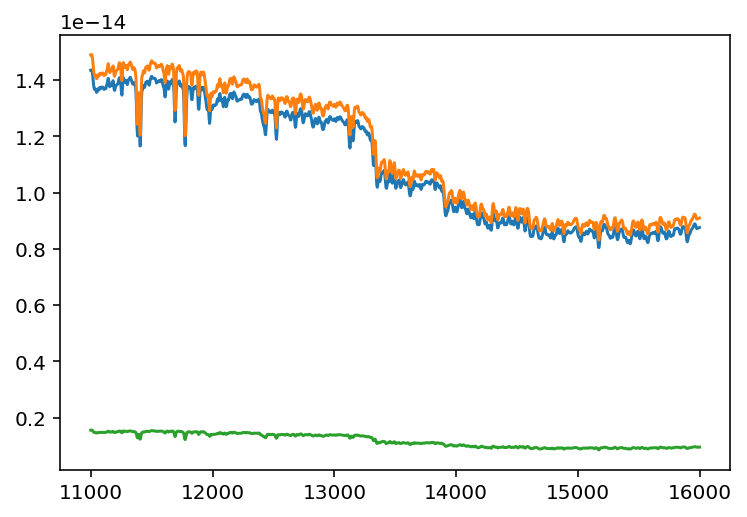

In [11]:
plt.plot(df.wl, df.model_composite)
plt.plot(df.wl, df.model_hot50)I 
plt.plot(df.wl, df.model_cool50)

Cool!! Next step is to "noise up" this spectrum and save it to an hdf5 file as synthetic data.